### Import necessary modules

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [66]:
df = pd.read_csv('./tweets_sent_new_df.csv', parse_dates=['datetime_new'], index_col='ids')

In [67]:
df.describe()

,score
count,715978.000000
mean,0.906193
std,3.164574
min,-104.000000
25%,-2.000000
50%,1.000000
75%,3.000000
max,32.000000


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715978 entries, nan to 2072532046.0
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype                    
---  ------        --------------   -----                    
 0   datetime_new  715978 non-null  datetime64[ns, UTC+01:00]
 1   score         715978 non-null  int64                    
 2   sentiment     715978 non-null  object                   
dtypes: datetime64[ns, UTC+01:00](1), int64(1), object(1)
memory usage: 21.8+ MB


#### Check the values of the sentiment column

In [69]:
df.sentiment.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

#### Only the sentiment column will be used after converting it to numerical values, and score can be discarded

In [70]:
df = df.sort_values(by='datetime_new')
df = df.drop(['score'], axis=1)
df.sentiment = df.sentiment.replace({'positive': 1, 'negative': -1, 'neutral':0})

In [71]:
df.head()

,datetime_new,sentiment
ids,,
1.467811e+09,2009-04-06 22:19:49+01:00,-1
1.467811e+09,2009-04-06 22:19:53+01:00,1
1.467811e+09,2009-04-06 22:19:57+01:00,-1
1.467811e+09,2009-04-06 22:19:57+01:00,-1
1.467812e+09,2009-04-06 22:20:03+01:00,-1


#### Check the first and last dates where there are tweets

In [72]:
print('Min date: %s' % df['datetime_new'].min().date())
print('Max date: %s' % df['datetime_new'].max().date())

Min date: 2009-04-06
Max date: 2009-06-25


#### Sentiment for all tweets will be aggregated daily for the dates where there are tweets

In [73]:
daily_series = df.groupby(df['datetime_new'].dt.date)['sentiment'].sum()
daily_series.head(10)

datetime_new
2009-04-06     331
2009-04-07    2233
2009-04-17     512
2009-04-18    3413
2009-04-19    4222
2009-04-20    2550
2009-04-21    1210
2009-05-01    1082
2009-05-02    3933
2009-05-03    4933
Name: sentiment, dtype: int64

#### Check the span of the entire period between the first and last dates where there are tweets

In [74]:
daily_series.index.max() - daily_series.index.min()

datetime.timedelta(days=80)

#### Create entries for the dates where there are NO tweets and set their aggregate sentiment value to NaN

In [75]:
idx = pd.date_range(daily_series.index.min(), daily_series.index.max())
idx

DatetimeIndex(['2009-04-06', '2009-04-07', '2009-04-08', '2009-04-09',
               '2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13',
               '2009-04-14', '2009-04-15', '2009-04-16', '2009-04-17',
               '2009-04-18', '2009-04-19', '2009-04-20', '2009-04-21',
               '2009-04-22', '2009-04-23', '2009-04-24', '2009-04-25',
               '2009-04-26', '2009-04-27', '2009-04-28', '2009-04-29',
               '2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03',
               '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07',
               '2009-05-08', '2009-05-09', '2009-05-10', '2009-05-11',
               '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15',
               '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19',
               '2009-05-20', '2009-05-21', '2009-05-22', '2009-05-23',
               '2009-05-24', '2009-05-25', '2009-05-26', '2009-05-27',
               '2009-05-28', '2009-05-29', '2009-05-30', '2009-05-31',
      

In [76]:
daily_series = daily_series.reindex(idx)
print(daily_series)

2009-04-06     331.0
2009-04-07    2233.0
2009-04-08       NaN
2009-04-09       NaN
2009-04-10       NaN
               ...  
2009-06-21    -824.0
2009-06-22    -831.0
2009-06-23   -1010.0
2009-06-24    -412.0
2009-06-25   -1278.0
Freq: D, Name: sentiment, Length: 81, dtype: float64


#### Plotting the daily aggregates would help to indenify the overall trend

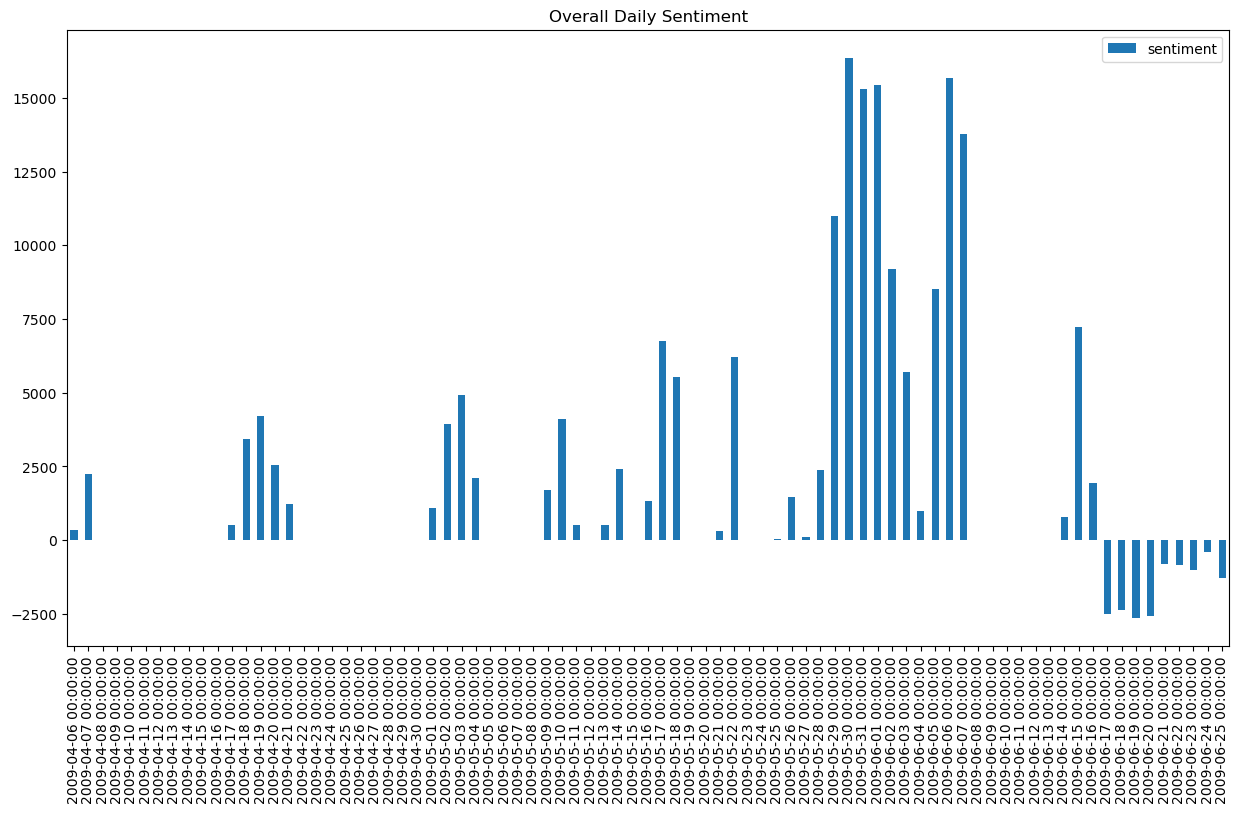

In [77]:
daily_series.plot.bar(figsize = (15, 8), title='Overall Daily Sentiment', legend=True)
plt.savefig('sent.png')

#### Explore if aggregating every 4 Hours for instance would show significant change in the trends

In [78]:
hourly_df = df.groupby(pd.Grouper(key='datetime_new', freq='4h')).sum() 
hourly_df.head()

,sentiment
datetime_new,
2009-04-06 20:00:00+01:00,331
2009-04-07 00:00:00+01:00,1059
2009-04-07 04:00:00+01:00,996
2009-04-07 08:00:00+01:00,178
2009-04-07 12:00:00+01:00,0


<Axes: title={'center': 'Sentiment Aggregates every 4 Hours'}, xlabel='datetime_new'>

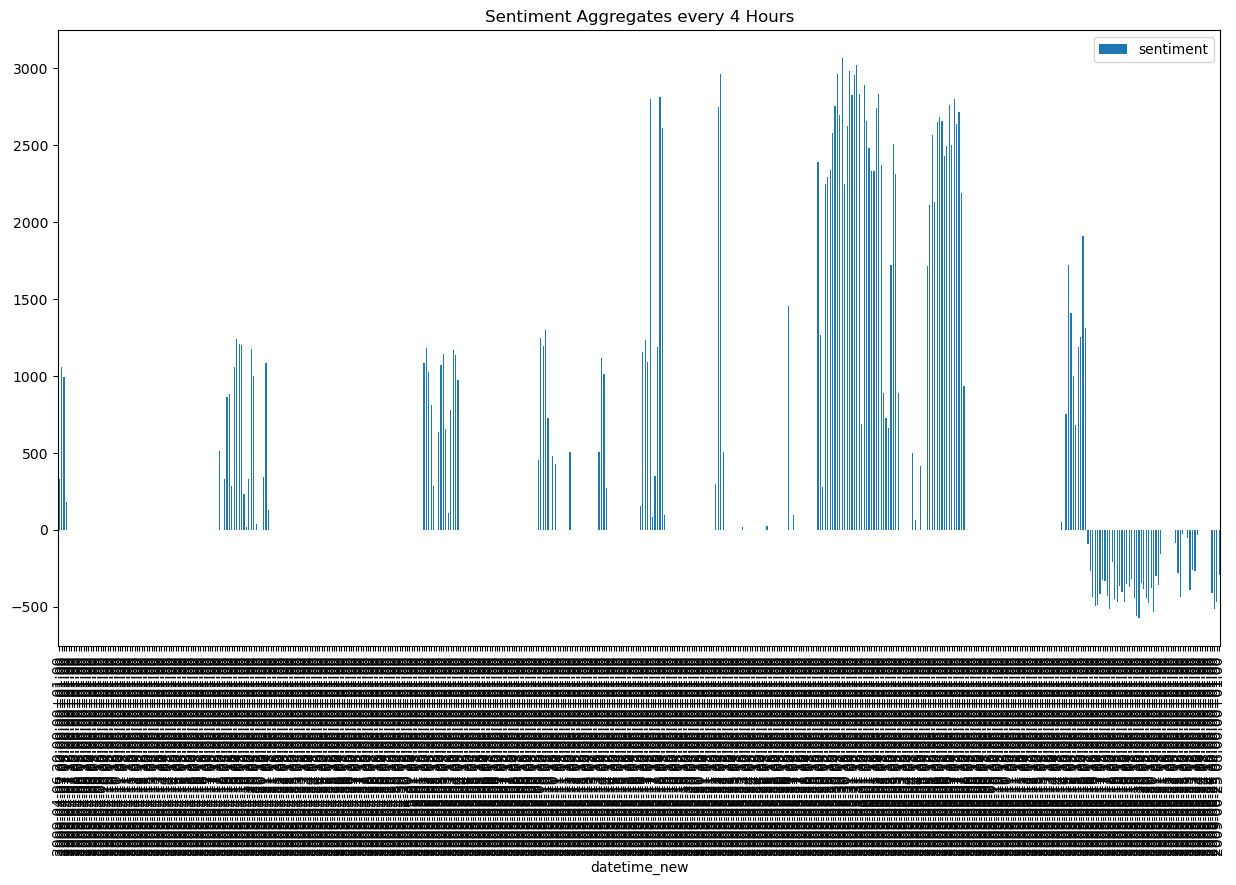

In [79]:
hourly_df.plot.bar(figsize = (15, 8),title='Sentiment Aggregates every 4 Hours', legend=True)

### It looks like hourly aggregates have little significance over daily ones. So daily will be used for further analysis.

### Next step would be to impute the sentiment over the missing dates
### Linear imputation based on the average of the before and after will be used

In [95]:
imputed_series = daily_series.interpolate() # will fill in based on the linear average of the before and after 
imputed_series.head()

2009-04-06     331.0
2009-04-07    2233.0
2009-04-08    2060.9
2009-04-09    1888.8
2009-04-10    1716.7
Freq: D, Name: sentiment, dtype: float64

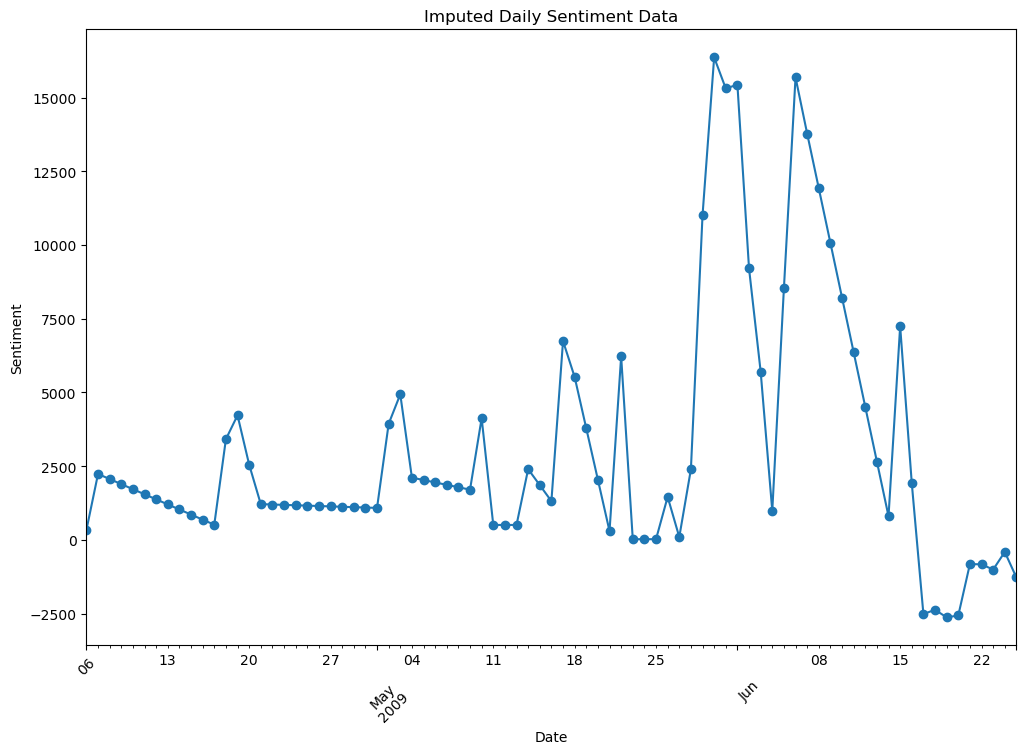

In [96]:
imputed_series.plot(marker='o', figsize = (12, 8))
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Imputed Daily Sentiment Data")
plt.savefig('impute.png')

## Modelling

#### Imputed Dataset can now be split into train and test parts

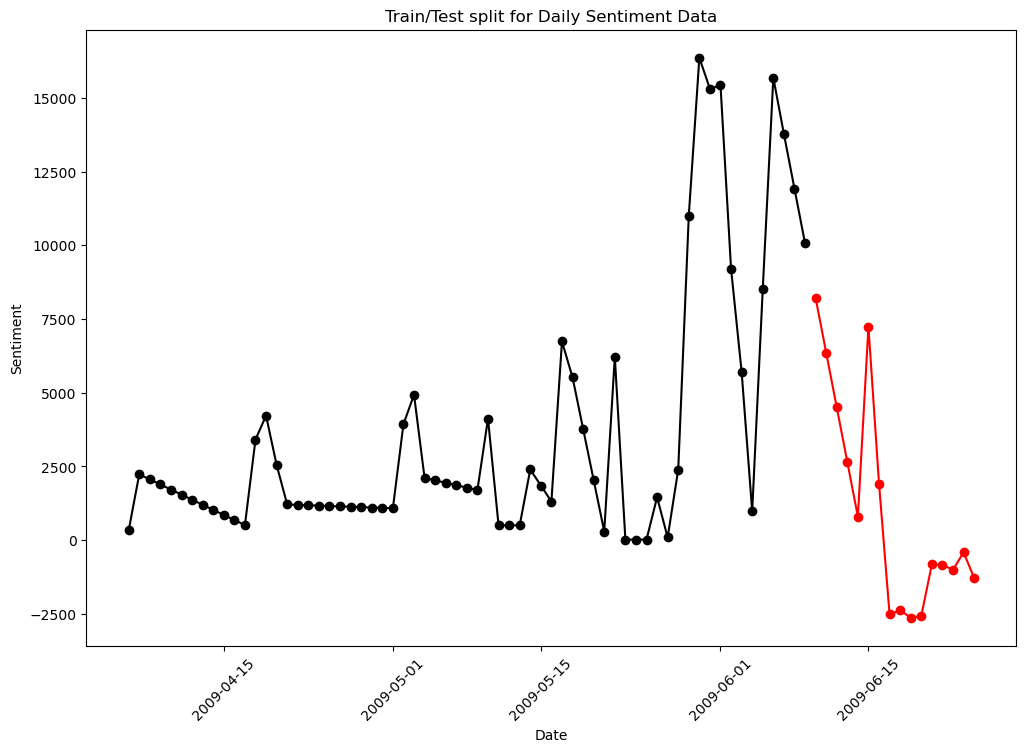

In [296]:
train = imputed_series[imputed_series.index < pd.to_datetime("2009-06-10", format='%Y-%m-%d')]
test = imputed_series[imputed_series.index >= pd.to_datetime("2009-06-10", format='%Y-%m-%d')]

plt.figure(figsize=(12,8))
plt.plot(train, color = "black", marker='o')
plt.plot(test, color = "red", marker='o')
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Daily Sentiment Data")
plt.savefig('split.png')
plt.show()


### 1. ARIMA
#### ARIMA is statical model that is based on moving average

In [297]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

#### An ARIMA task has three parameters. The first parameter corresponds to the lagging (past values), the second corresponds to differencing (this is what makes non-stationary data stationary), and the last parameter corresponds to the white noise (for modeling shock events). 
#### Doesn't look like there is seasonality, especially that the dataset only contains around 80 days


### Forecasting for 1 week:

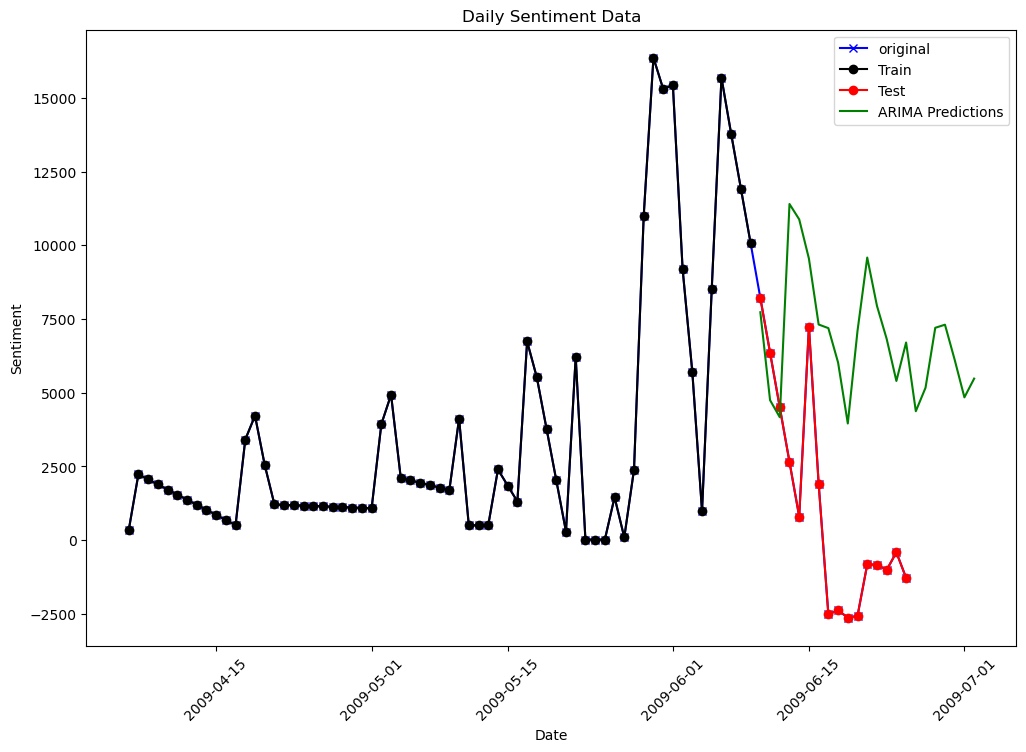

In [308]:
y = train
ARIMAmodel = ARIMA(y, order = (10, 0, 2))
ARIMAmodel = ARIMAmodel.fit()

n_future_predictions = 7 # make pridiction for 1 week

# y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred = ARIMAmodel.get_forecast(len(test.index) + n_future_predictions)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
# y_pred_df.index = test.index
# Create indexes for the period p = Test data + n_fututre_predictions value = 10/06 -> 25/06 + 7 days
y_pred_df.index = pd.date_range(pd.to_datetime("2009-06-10", format='%Y-%m-%d'), pd.to_datetime("2009-07-02", format='%Y-%m-%d'))
y_pred_out = y_pred_df["Predictions"] 


plt.figure(figsize=(12,8))
plt.plot(imputed_series, color = "blue", marker='x', label = 'original')
plt.plot(train, color = "black", marker='o', label = 'Train')
plt.plot(test, color = "red", marker='o', label = 'Test')
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Daily Sentiment Data")


plt.plot(y_pred_out, color='Green', label = 'ARIMA Predictions')
plt.legend()
plt.savefig('arima.png')
plt.show()

### Hyperparameter tunning 

In [302]:
# # evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train_part, test_part, arima_order):
    history = [x for x in train_part]
    predictions = list()
    for t in range(len(test_part)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test_part[t])
    rmse = sqrt(mean_squared_error(test_part, predictions))
    return rmse

In [303]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train_part, test_part, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train_part, test_part, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [306]:
# evaluate parameters
p_values = [0,1,2,6]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=4234.841
ARIMA(0, 0, 1) RMSE=3017.398
ARIMA(0, 0, 2) RMSE=3243.472
ARIMA(0, 1, 0) RMSE=2634.040
ARIMA(0, 1, 1) RMSE=2730.188
ARIMA(0, 1, 2) RMSE=2867.847
ARIMA(0, 2, 0) RMSE=3857.069
ARIMA(0, 2, 1) RMSE=2670.473
ARIMA(0, 2, 2) RMSE=2763.888
ARIMA(1, 0, 0) RMSE=2482.998
ARIMA(1, 0, 1) RMSE=2564.121
ARIMA(1, 0, 2) RMSE=2686.902
ARIMA(1, 1, 0) RMSE=2706.523
ARIMA(1, 1, 1) RMSE=2625.206
ARIMA(1, 1, 2) RMSE=2835.908
ARIMA(1, 2, 0) RMSE=3515.215
ARIMA(1, 2, 1) RMSE=2742.369
ARIMA(1, 2, 2) RMSE=2757.074
ARIMA(2, 0, 0) RMSE=2586.414
ARIMA(2, 0, 1) RMSE=2596.785
ARIMA(2, 0, 2) RMSE=2729.275
ARIMA(2, 1, 0) RMSE=2719.221
ARIMA(2, 1, 1) RMSE=2993.025
ARIMA(2, 1, 2) RMSE=3154.915
ARIMA(2, 2, 0) RMSE=3154.896
ARIMA(2, 2, 1) RMSE=2761.520
ARIMA(2, 2, 2) RMSE=3299.003
ARIMA(6, 0, 0) RMSE=2784.020
ARIMA(6, 0, 1) RMSE=2727.427
ARIMA(6, 0, 2) RMSE=2952.697
ARIMA(6, 1, 0) RMSE=3314.666
ARIMA(6, 1, 1) RMSE=3363.881
ARIMA(6, 1, 2) RMSE=3806.682
ARIMA(6, 2, 0) RMSE=3796.737
ARIMA(6, 2, 1)

Applying the best values for the paramerters (1,0,0) to see if the model will show better resutls

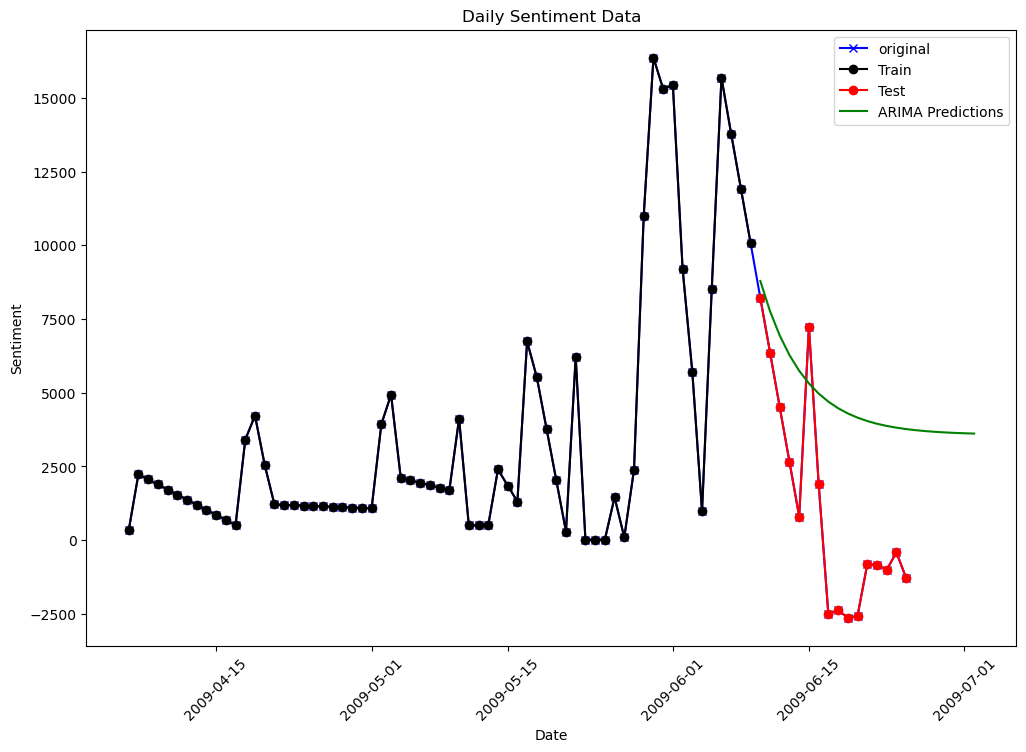

In [309]:
y = train
ARIMAmodel = ARIMA(y, order = (1, 0, 0))
ARIMAmodel = ARIMAmodel.fit()

n_future_predictions = 7 # make pridiction for 1 week

# y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred = ARIMAmodel.get_forecast(len(test.index) + n_future_predictions)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
# y_pred_df.index = test.index
# Create indexes for the period p = Test data + n_fututre_predictions value = 10/06 -> 25/06 + 7 days
y_pred_df.index = pd.date_range(pd.to_datetime("2009-06-10", format='%Y-%m-%d'), pd.to_datetime("2009-07-02", format='%Y-%m-%d'))
y_pred_out = y_pred_df["Predictions"] 


plt.figure(figsize=(12,8))
plt.plot(imputed_series, color = "blue", marker='x', label = 'original')
plt.plot(train, color = "black", marker='o', label = 'Train')
plt.plot(test, color = "red", marker='o', label = 'Test')
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Daily Sentiment Data")


plt.plot(y_pred_out, color='Green', label = 'ARIMA Predictions')
plt.legend()
plt.savefig('arima_hyper.png')
plt.show()

Yes, the forecast is really better as the line isgetting down towards the negative sentiment.

### 2. LSTM Based Model

In [159]:
from sklearn.preprocessing import MinMaxScaler

#### Create a dataset by extracting the sentiment values

In [160]:
dataset = imputed_series.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

In [161]:
dataset.shape

(81, 1)

#### LSTM is sensitive to value scales, so the dataset values will be scaled between 0 to 1

In [162]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#### Split the dataset into train and test

In [163]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

60 21


#### The problem now needs to be transformed from a timeseries into dataset/label format, so that LSTM can be used
#### The following function will generate labels for both train and test parts by shifting the timeseries by 1, i.e. the label of today's prediction is tomorrow's sentiment value
#### It also considers not only looking at one sample (i.e. today's) to make the predication, but rather taking historical (look_back) samples into consideration too, to make better predictions

In [164]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Generate Train/labels and Test/labels

In [165]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [166]:
trainX.shape, trainY.shape

((58, 1), (58,))

#### Input dataset to the model needs to be in a specific format [samples, time steps, features]

In [167]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [168]:
trainX.shape, trainY.shape

((58, 1, 1), (58,))

#### Import necessary modules and models

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [170]:
# create and fit a simple LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=70, batch_size=1, verbose=2)

Epoch 1/70
58/58 - 1s - loss: 0.0940 - 1s/epoch - 24ms/step
Epoch 2/70
58/58 - 0s - loss: 0.0614 - 77ms/epoch - 1ms/step
Epoch 3/70
58/58 - 0s - loss: 0.0428 - 77ms/epoch - 1ms/step
Epoch 4/70
58/58 - 0s - loss: 0.0342 - 87ms/epoch - 2ms/step
Epoch 5/70
58/58 - 0s - loss: 0.0314 - 84ms/epoch - 1ms/step
Epoch 6/70
58/58 - 0s - loss: 0.0301 - 80ms/epoch - 1ms/step
Epoch 7/70
58/58 - 0s - loss: 0.0292 - 88ms/epoch - 2ms/step
Epoch 8/70
58/58 - 0s - loss: 0.0286 - 85ms/epoch - 1ms/step
Epoch 9/70
58/58 - 0s - loss: 0.0279 - 84ms/epoch - 1ms/step
Epoch 10/70
58/58 - 0s - loss: 0.0275 - 85ms/epoch - 1ms/step
Epoch 11/70
58/58 - 0s - loss: 0.0267 - 80ms/epoch - 1ms/step
Epoch 12/70
58/58 - 0s - loss: 0.0261 - 84ms/epoch - 1ms/step
Epoch 13/70
58/58 - 0s - loss: 0.0253 - 84ms/epoch - 1ms/step
Epoch 14/70
58/58 - 0s - loss: 0.0248 - 84ms/epoch - 1ms/step
Epoch 15/70
58/58 - 0s - loss: 0.0242 - 86ms/epoch - 1ms/step
Epoch 16/70
58/58 - 0s - loss: 0.0240 - 86ms/epoch - 1ms/step
Epoch 17/70
58/58 

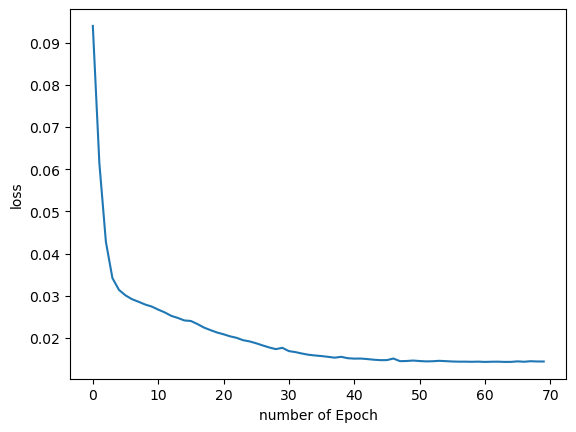

In [171]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('number of Epoch')
plt.savefig('epoch.png')

In [172]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert both train and test predictions to their oringinal values using the scaler
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 21ms/step
Train Score: 2257.85 RMSE
Test Score: 2945.62 RMSE


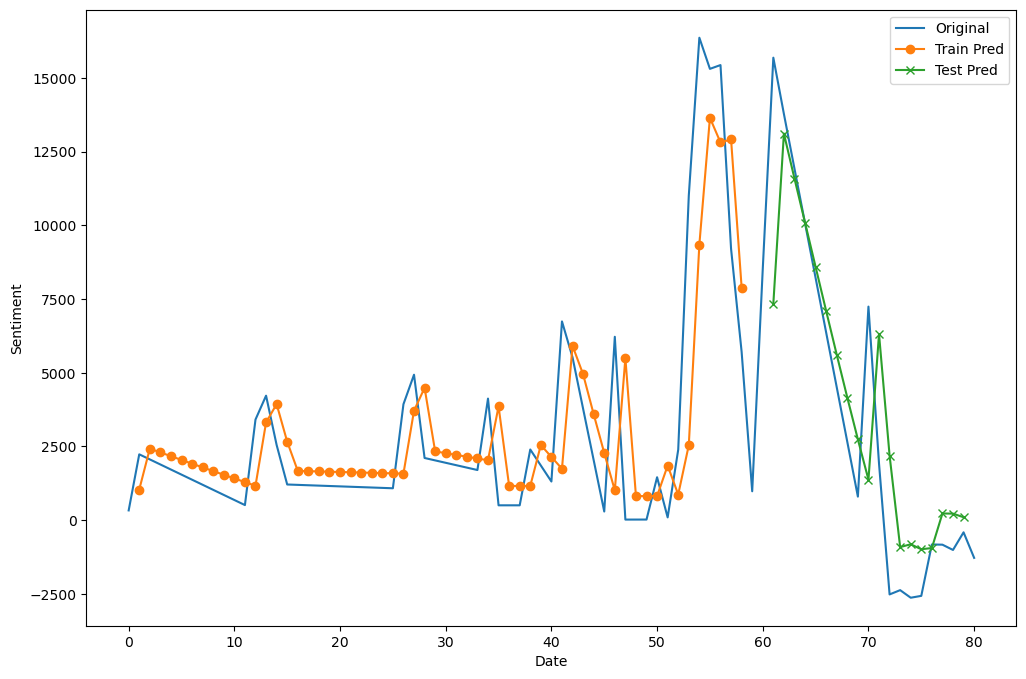

In [173]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot,marker='o', label='Train Pred')
plt.plot(testPredictPlot,marker='x', label='Test Pred')
plt.legend()
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.savefig('lstmPred.png')
plt.show()


#### The prediction results for both Train and Test data is very good, the model can now be used to make multiple step predictions into the future

#### The following function will create an input sample that would create one future prediction, the goal is to use it to generate future samples after appending the predictions to the original dataset

In [174]:
def create_forecast_dataset(dataset, look_back=1):
    dataX = np.array( dataset[-1-look_back+1:,0] ).reshape(-1,1)
    # reshape input to be [samples, time steps, features]
    dataX = np.reshape(dataX, (dataX.shape[1], 1, dataX.shape[0]))
    return dataX

#### Create first sample to predict first future sample

In [175]:
forecast_dataset = create_forecast_dataset(dataset, look_back)

In [176]:
forecast_dataset.shape

(1, 1, 1)

In [177]:
dataset.shape

(81, 1)

#### Depending on how make future prediction steps are needed (n_future_preds), an input sample will be generated using the (create_forecast_dataset) function, then it will be used to predict the next sample, which in turn will be appended to the original dataset, and a new input sample will be created and so on and so forth

In [178]:
n_future_preds = 7

# copy the original dataset into a new_dataset that the n_future_preds will be appended to
new_dataset = dataset

for i in range(0, n_future_preds):
    print("predicting date number: {}".format(i+1))
    
    # Predict next sample
    next_date_pred = model.predict(forecast_dataset)
    
    # Append the predicted sample to the dataset and create a new forecast sample based on the look_back
    new_dataset = np.append(new_dataset, next_date_pred, axis=0)
    forecast_dataset = create_forecast_dataset(new_dataset,look_back)

predicting date number: 1
1/1 [==============================] - 0s 20ms/step
predicting date number: 2
1/1 [==============================] - 0s 24ms/step
predicting date number: 3
1/1 [==============================] - 0s 23ms/step
predicting date number: 4
1/1 [==============================] - 0s 21ms/step
predicting date number: 5
1/1 [==============================] - 0s 22ms/step
predicting date number: 6
1/1 [==============================] - 0s 16ms/step
predicting date number: 7
1/1 [==============================] - 0s 16ms/step


In [149]:
dataset.shape, new_dataset.shape

((81, 1), (88, 1))

#### Plot Original dataset, Train and Test predictions, as well as future predictions

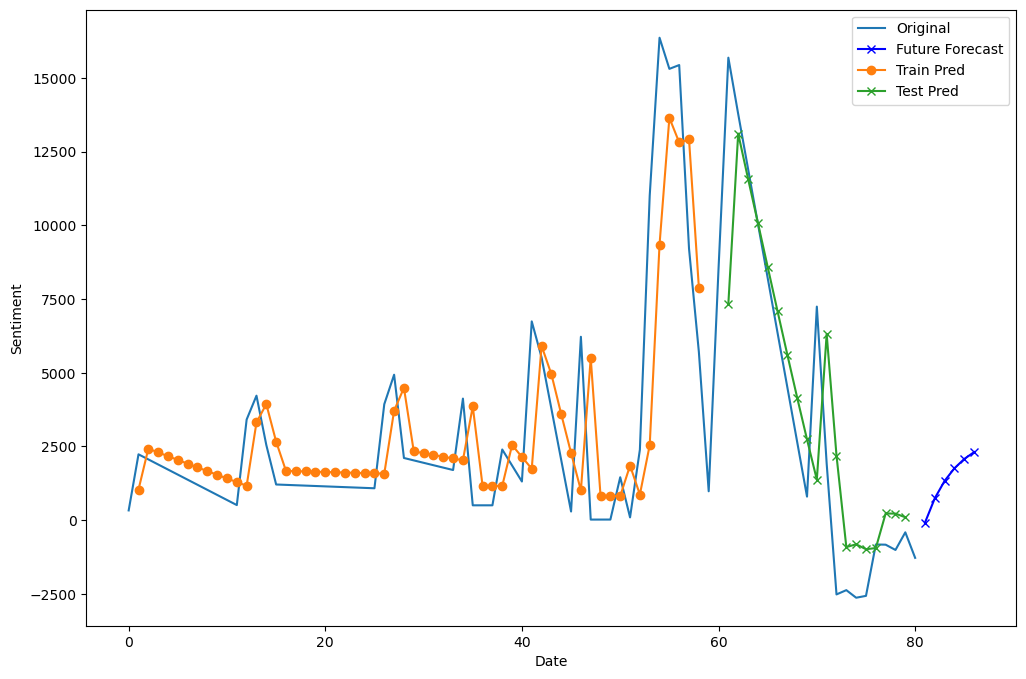

In [179]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# shift n_future_preds for plotting
futurePredicPlot = np.empty_like(new_dataset)
futurePredicPlot[:,:] = np.nan
futurePredicPlot[len(dataset):len(new_dataset)-1, :] = new_dataset[len(dataset):len(new_dataset)-1, :]
# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(scaler.inverse_transform(futurePredicPlot), label='Future Forecast', color='Blue', marker ='x')
plt.plot(trainPredictPlot,marker='o', label='Train Pred')
plt.plot(testPredictPlot,marker='x', label='Test Pred')
plt.legend()
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.savefig('lstm7.png')
plt.show()

    
    

#### A New model could be trained with a higher look_back value (e.g. 5) and more future samples (e.g. n_future_preds = 30)

In [180]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [181]:
model2 = Sequential()
model2.add(LSTM(5, input_shape=(1, look_back)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model2.fit(trainX, trainY, epochs=60, batch_size=1, verbose=2)

Epoch 1/60
54/54 - 1s - loss: 0.1171 - 1s/epoch - 24ms/step
Epoch 2/60
54/54 - 0s - loss: 0.0738 - 68ms/epoch - 1ms/step
Epoch 3/60
54/54 - 0s - loss: 0.0513 - 77ms/epoch - 1ms/step
Epoch 4/60
54/54 - 0s - loss: 0.0423 - 76ms/epoch - 1ms/step
Epoch 5/60
54/54 - 0s - loss: 0.0389 - 74ms/epoch - 1ms/step
Epoch 6/60
54/54 - 0s - loss: 0.0375 - 75ms/epoch - 1ms/step
Epoch 7/60
54/54 - 0s - loss: 0.0371 - 76ms/epoch - 1ms/step
Epoch 8/60
54/54 - 0s - loss: 0.0354 - 72ms/epoch - 1ms/step
Epoch 9/60
54/54 - 0s - loss: 0.0343 - 72ms/epoch - 1ms/step
Epoch 10/60
54/54 - 0s - loss: 0.0335 - 74ms/epoch - 1ms/step
Epoch 11/60
54/54 - 0s - loss: 0.0324 - 76ms/epoch - 1ms/step
Epoch 12/60
54/54 - 0s - loss: 0.0318 - 76ms/epoch - 1ms/step
Epoch 13/60
54/54 - 0s - loss: 0.0311 - 74ms/epoch - 1ms/step
Epoch 14/60
54/54 - 0s - loss: 0.0301 - 75ms/epoch - 1ms/step
Epoch 15/60
54/54 - 0s - loss: 0.0297 - 76ms/epoch - 1ms/step
Epoch 16/60
54/54 - 0s - loss: 0.0290 - 78ms/epoch - 1ms/step
Epoch 17/60
54/54 

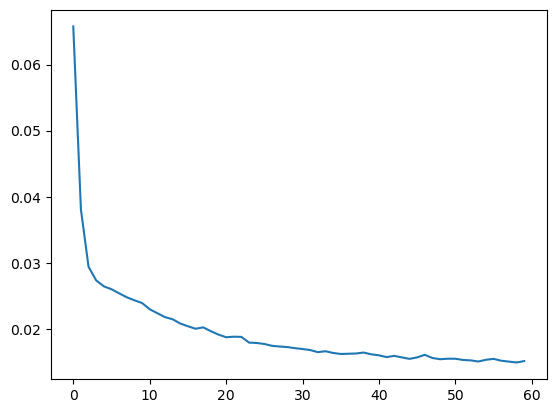

In [154]:
plt.plot(history2.history['loss'])
plt.savefig('epoch30days.png')

In [182]:
# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

# invert both train and test predictions to their oringinal values using the scaler
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 24ms/step
Train Score: 2370.65 RMSE
Test Score: 3292.77 RMSE


In [183]:
forecast_dataset = create_forecast_dataset(dataset, look_back)

In [184]:
n_future_preds = 30

# copy the original dataset into a new_dataset that the n_future_preds will be appended to
new_dataset = dataset

for i in range(0, n_future_preds):
    print("predicting date number: {}".format(i+1))
    
    # Predict next sample
    next_date_pred = model2.predict(forecast_dataset)
    
    # Append the predicted sample to the dataset and create a new forecast sample based on the look_back
    new_dataset = np.append(new_dataset, next_date_pred, axis=0)
    forecast_dataset = create_forecast_dataset(new_dataset,look_back)

predicting date number: 1
1/1 [==============================] - 0s 23ms/step
predicting date number: 2
1/1 [==============================] - 0s 23ms/step
predicting date number: 3
1/1 [==============================] - 0s 22ms/step
predicting date number: 4
1/1 [==============================] - 0s 31ms/step
predicting date number: 5
1/1 [==============================] - 0s 10ms/step
predicting date number: 6
1/1 [==============================] - 0s 32ms/step
predicting date number: 7
1/1 [==============================] - 0s 16ms/step
predicting date number: 8
1/1 [==============================] - 0s 18ms/step
predicting date number: 9
1/1 [==============================] - 0s 21ms/step
predicting date number: 10
1/1 [==============================] - 0s 22ms/step
predicting date number: 11
1/1 [==============================] - 0s 14ms/step
predicting date number: 12
1/1 [==============================] - 0s 19ms/step
predicting date number: 13
1/1 [=============================

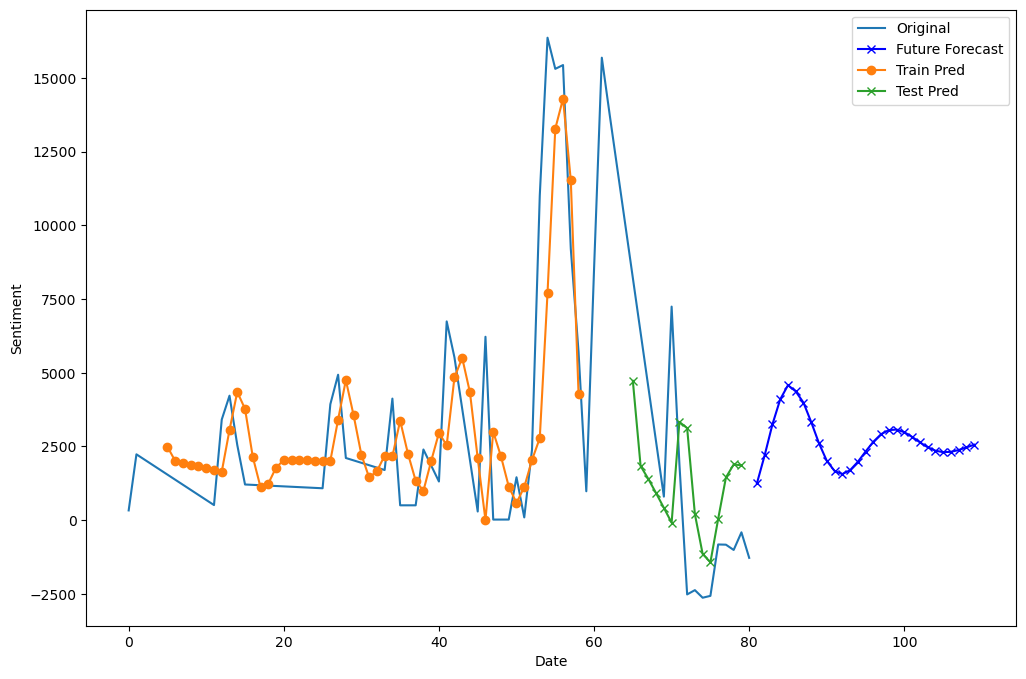

In [185]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# shift n_future_preds for plotting
futurePredicPlot = np.empty_like(new_dataset)
futurePredicPlot[:,:] = np.nan
futurePredicPlot[len(dataset):len(new_dataset)-1, :] = new_dataset[len(dataset):len(new_dataset)-1, :]
# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(scaler.inverse_transform(futurePredicPlot), label='Future Forecast', color='Blue', marker ='x')
plt.plot(trainPredictPlot,marker='o', label='Train Pred')
plt.plot(testPredictPlot,marker='x', label='Test Pred')
plt.legend()
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.savefig('lstm30.png')
plt.show()


#### A New model could be trained with a higher look_back value (e.g. 5) and more future samples (e.g. n_future_preds = 90)

In [186]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [187]:
model3 = Sequential()
model3.add(LSTM(5, input_shape=(1, look_back)))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
history3 = model3.fit(trainX, trainY, epochs=90, batch_size=1, verbose=2)

Epoch 1/90
54/54 - 1s - loss: 0.1149 - 1s/epoch - 22ms/step
Epoch 2/90
54/54 - 0s - loss: 0.0708 - 68ms/epoch - 1ms/step
Epoch 3/90
54/54 - 0s - loss: 0.0508 - 84ms/epoch - 2ms/step
Epoch 4/90
54/54 - 0s - loss: 0.0409 - 73ms/epoch - 1ms/step
Epoch 5/90
54/54 - 0s - loss: 0.0371 - 75ms/epoch - 1ms/step
Epoch 6/90
54/54 - 0s - loss: 0.0357 - 71ms/epoch - 1ms/step
Epoch 7/90
54/54 - 0s - loss: 0.0348 - 73ms/epoch - 1ms/step
Epoch 8/90
54/54 - 0s - loss: 0.0338 - 73ms/epoch - 1ms/step
Epoch 9/90
54/54 - 0s - loss: 0.0333 - 74ms/epoch - 1ms/step
Epoch 10/90
54/54 - 0s - loss: 0.0321 - 91ms/epoch - 2ms/step
Epoch 11/90
54/54 - 0s - loss: 0.0314 - 98ms/epoch - 2ms/step
Epoch 12/90
54/54 - 0s - loss: 0.0307 - 86ms/epoch - 2ms/step
Epoch 13/90
54/54 - 0s - loss: 0.0310 - 96ms/epoch - 2ms/step
Epoch 14/90
54/54 - 0s - loss: 0.0295 - 83ms/epoch - 2ms/step
Epoch 15/90
54/54 - 0s - loss: 0.0287 - 84ms/epoch - 2ms/step
Epoch 16/90
54/54 - 0s - loss: 0.0283 - 94ms/epoch - 2ms/step
Epoch 17/90
54/54 

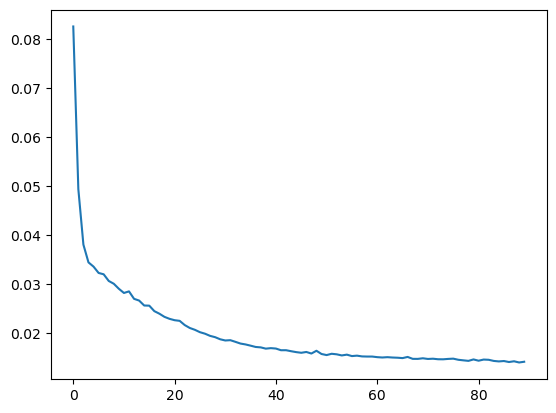

In [52]:
plt.plot(history3.history['loss'])

In [188]:
# make predictions
trainPredict = model3.predict(trainX)
testPredict = model3.predict(testX)

# invert both train and test predictions to their oringinal values using the scaler
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 32ms/step
Train Score: 2186.66 RMSE
Test Score: 3167.31 RMSE


In [54]:
forecast_dataset = create_forecast_dataset(dataset, look_back)

In [189]:
n_future_preds = 90

# copy the original dataset into a new_dataset that the n_future_preds will be appended to
new_dataset = dataset

for i in range(0, n_future_preds):
    print("predicting date number: {}".format(i+1))
    
    # Predict next sample
    next_date_pred = model3.predict(forecast_dataset)
    
    # Append the predicted sample to the dataset and create a new forecast sample based on the look_back
    new_dataset = np.append(new_dataset, next_date_pred, axis=0)
    forecast_dataset = create_forecast_dataset(new_dataset,look_back)

predicting date number: 1
1/1 [==============================] - 0s 26ms/step
predicting date number: 2
1/1 [==============================] - 0s 20ms/step
predicting date number: 3
1/1 [==============================] - 0s 19ms/step
predicting date number: 4
1/1 [==============================] - 0s 18ms/step
predicting date number: 5
1/1 [==============================] - 0s 19ms/step
predicting date number: 6
1/1 [==============================] - 0s 20ms/step
predicting date number: 7
1/1 [==============================] - 0s 12ms/step
predicting date number: 8
1/1 [==============================] - 0s 17ms/step
predicting date number: 9
1/1 [==============================] - 0s 32ms/step
predicting date number: 10
1/1 [==============================] - 0s 20ms/step
predicting date number: 11
1/1 [==============================] - 0s 15ms/step
predicting date number: 12
1/1 [==============================] - 0s 16ms/step
predicting date number: 13
1/1 [=============================

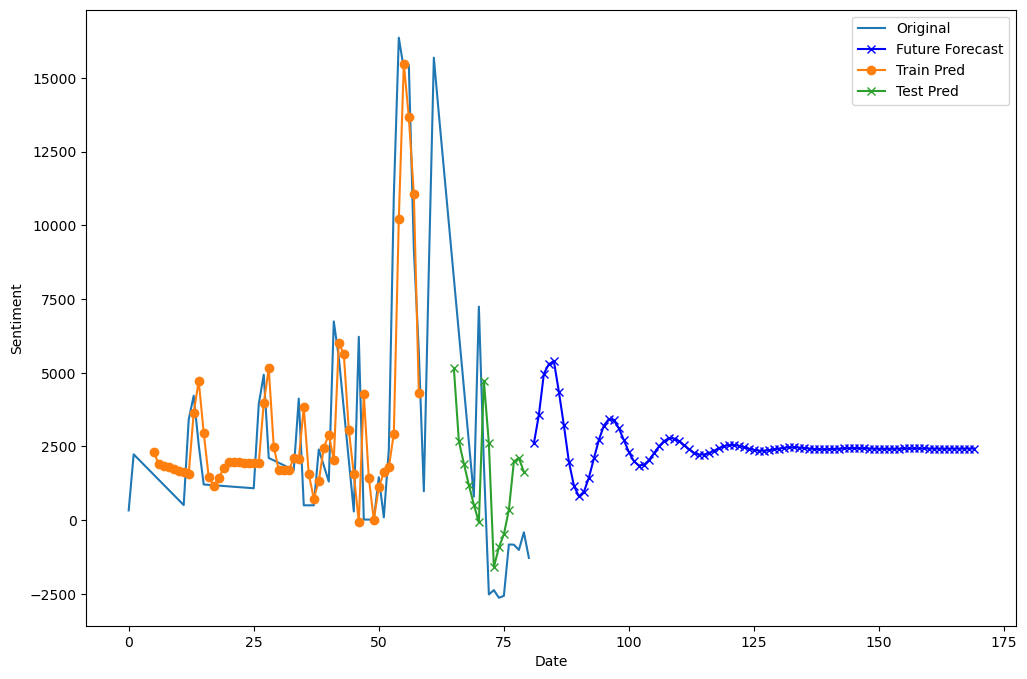

In [190]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# shift n_future_preds for plotting
futurePredicPlot = np.empty_like(new_dataset)
futurePredicPlot[:,:] = np.nan
futurePredicPlot[len(dataset):len(new_dataset)-1, :] = new_dataset[len(dataset):len(new_dataset)-1, :]
# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(scaler.inverse_transform(futurePredicPlot), label='Future Forecast', color='Blue', marker ='x')
plt.plot(trainPredictPlot,marker='o', label='Train Pred')
plt.plot(testPredictPlot,marker='x', label='Test Pred')
plt.legend()
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.savefig('lstm90.png')
plt.show()
